In [77]:
from datasets import load_dataset, DatasetDict
from datasets import ClassLabel
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, get_linear_schedule_with_warmup, AdamW
from transformers import AutoTokenizer
import numpy as np
import evaluate

In [78]:
MODEL = "distilbert-base-uncased"
#MODEL = "google/bigbird-roberta-base"
#MODEL = "bert-base-uncased"
MAX_STEPS = 500

#explicitly load dataset from local file (hugging face insists on a constant train/test split when loading from hub)
dataset = load_dataset('csv', data_files="data/coarse-labeled-urls-headers.csv")
dataset = dataset.shuffle()
dataset = dataset['train'].train_test_split(test_size=0.15)

tokenizer = AutoTokenizer.from_pretrained(MODEL)
labels = ClassLabel(names_file="data/coarse_labels.txt")
features = ['url', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']

labels_to_keep = set(labels.names)

# Filter the dataset based on labels
filtered_dataset = dataset.filter(lambda example: example['coarse_label'] in labels_to_keep)

def tokenize_function(batch):
    # Combine relevant features into a single string for tokenization
    text_to_tokenize = " ".join([str(batch[feature]) for feature in features])
    tokens = tokenizer(text_to_tokenize, padding='max_length', truncation=True)
    tokens["label"] = labels.str2int(batch["coarse_label"])
    return tokens

# Tokenize the datasets
tokenized_train_dataset = filtered_dataset["train"].map(tokenize_function, batched=False)
tokenized_test_dataset = filtered_dataset["test"].map(tokenize_function, batched=False)

# Optionally, you can cast the "label" column to ClassLabel
tokenized_train_dataset = tokenized_train_dataset.cast_column("label", labels)
tokenized_test_dataset = tokenized_test_dataset.cast_column("label", labels)

Filter:   0%|          | 0/3781 [00:00<?, ? examples/s]

Filter:   0%|          | 0/668 [00:00<?, ? examples/s]

Map:   0%|          | 0/3781 [00:00<?, ? examples/s]

Map:   0%|          | 0/668 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/3781 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/668 [00:00<?, ? examples/s]

In [79]:
classifier = pipeline("text-classification", model=MODEL, framework="pt", tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=8)
#training_args = TrainingArguments(output_dir="test_trainer_1.1", evaluation_strategy="epoch", max_steps=1)#, push_to_hub=True)
training_args = TrainingArguments(
    output_dir="distilbert_coarse_1.1", 
    evaluation_strategy="epoch", 
    save_strategy='epoch', 
    num_train_epochs=2,
    learning_rate=5e-5,  # Initial learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=0,  # Number of warmup steps
    weight_decay=0.0 # Weight decay coefficient)
)
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)  # Define the optimizer
metric = evaluate.load("accuracy")

# Calculate the total number of training steps
total_steps = len(tokenized_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=total_steps
)

eval_predictions = []
eval_labels = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    #store the predictions and labels
    eval_predictions.extend(predictions.tolist())
    eval_labels.extend(labels.tolist())
    
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    optimizers = (optimizer, scheduler)
)

trainer.train()

# These will push a new model version to the Hugging Face Hub upon training completion
#trainer.push_to_hub("PDAP/url-classifier-test")
#tokenizer.push_to_hub("PDAP/url-classifier-test")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/bonjarlow/Desktop/pdap/pdapenv/lib/python3.9/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` 

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.920929,0.688623
2,1.145000,0.882684,0.711078


TrainOutput(global_step=946, training_loss=0.9118326521827101, metrics={'train_runtime': 12589.4556, 'train_samples_per_second': 0.601, 'train_steps_per_second': 0.075, 'total_flos': 1001825653997568.0, 'train_loss': 0.9118326521827101, 'epoch': 2.0})

In [7]:
# Evaluate the final model on the test dataset
evaluation_results = trainer.evaluate()

In [8]:
# Access the final accuracy from the evaluation results
final_accuracy = evaluation_results["eval_accuracy"]
print("Final Accuracy:", final_accuracy)

Final Accuracy: 0.4904153354632588


### Can I load the model and train for additional epochs

In [26]:
# Define your model and training arguments as before
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=18)
training_args = TrainingArguments(output_dir="bert_1.1", evaluation_strategy="epoch", save_strategy='epoch', num_train_epochs=1)  # Set num_train_epochs to 2 to continue training for another epoch

# Load the saved state of the model
model_path = "bert_1.1/checkpoint-437/"  # Specify the path where the model was saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Define your trainer as before
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

# Continue training for another epoch
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.475354,0.559105


Checkpoint destination directory bert_1.1/checkpoint-437 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=437, training_loss=1.5890977802756723, metrics={'train_runtime': 12228.6065, 'train_samples_per_second': 0.286, 'train_steps_per_second': 0.036, 'total_flos': 919705242101760.0, 'train_loss': 1.5890977802756723, 'epoch': 1.0})

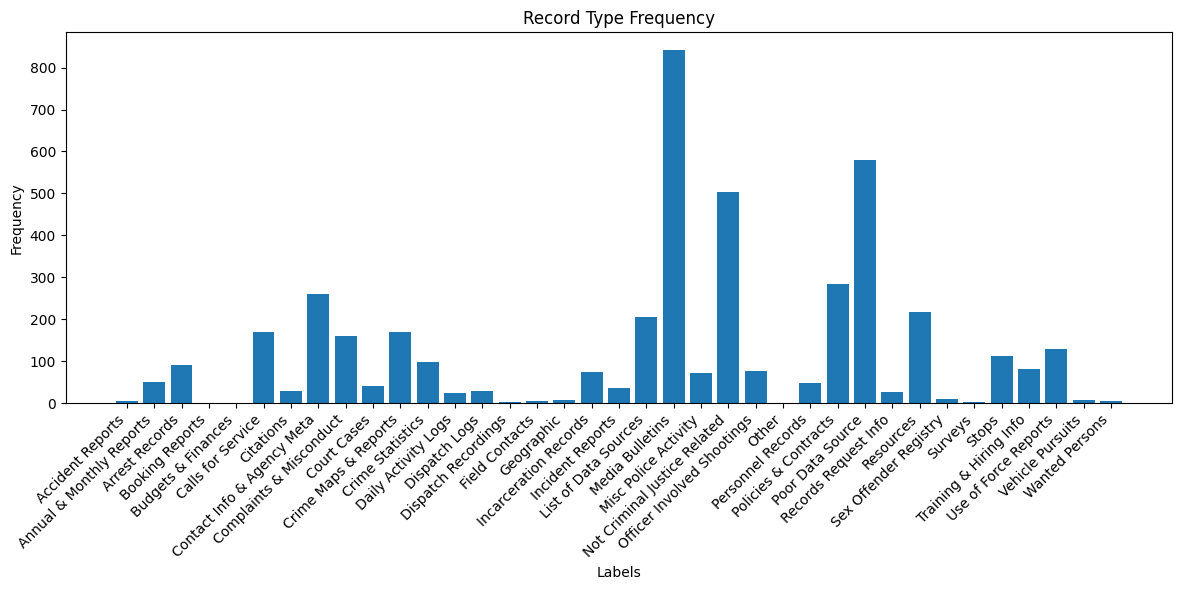

Arrest Records
Calls for Service
Contact Info & Agency Meta
Complaints & Misconduct
Crime Maps & Reports
Crime Statistics
Incarceration Records
List of Data Sources
Media Bulletins
Misc Police Activity
Not Criminal Justice Related
Officer Involved Shootings
Policies & Contracts
Poor Data Source
Resources
Stops
Training & Hiring Info
Use of Force Reports


In [11]:
import csv
import matplotlib.pyplot as plt

# Function to read labels from a text file
def read_labels(file_path):
    with open(file_path, 'r') as file:
        labels = [line.strip() for line in file]
    return labels

# Function to create a histogram
def create_histogram(csv_file, labels_file):
    # Read labels from the text file
    labels = read_labels(labels_file)

    # Initialize a dictionary to store counts for each label
    label_counts = {label: 0 for label in labels}

    # Read the second column of the CSV file and update counts
    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the header
        for row in csv_reader:
            if len(row) >= 2:
                label = row[1].strip()
                if label in label_counts:
                    label_counts[label] += 1

    #Create histogram plot
    plt.figure(figsize=(12, 6))
    plt.bar(labels, [label_counts[label] for label in labels])
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.title('Record Type Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    for (label, count) in label_counts.items():
        if (count> 50):
            print(label)

# Example usage
csv_file_path = 'data/all-labeled-urls.csv'
labels_file_path = 'data/labels.txt'
create_histogram(csv_file_path, labels_file_path)

In [56]:
filtered_dataset["train"]["h2"]

['[]',
 '["Available Data"]',
 '["Find Posts By Topic", "You might also like...", "Police", "City-Wide Information", "Top Requests", "Policies"]',
 None,
 '["How  can we help?", "Recent News Articles", "\\nHow to use a HAWK signal\\n", "\\nWhitestown Town Council Announces 2024 Board Appointments\\n", "Visit Us", "Contact Us", "Stay Connected"]',
 '["Menu"]',
 None,
 '["Menu"]',
 '[]',
 '[]',
 '["Menu", "\\n  Categories > Public Safety\\n  \\n", "\\n        Sort\\n      ", "\\n    Sort by Most Relevant\\n    \\n", "\\n        Filter\\n      ", "\\nAuthority\\n\\n", "\\nCategories\\n\\n", "\\nView Types\\n\\n", "\\nTags\\n\\n", "\\nActive Calls for Northeast Division / Dallas Police Department\\nCOMMUNITY CREATED\\n", "\\nDallas Police Active Calls\\n", "\\nActive Calls for Southeast Division / Dallas Police Department\\nCOMMUNITY CREATED\\n", "\\nActive Calls in DPD North Central Division\\nCOMMUNITY CREATED\\n", "\\nActive Calls in DPD Northeast Division\\nCOMMUNITY CREATED\\n", "\\nA

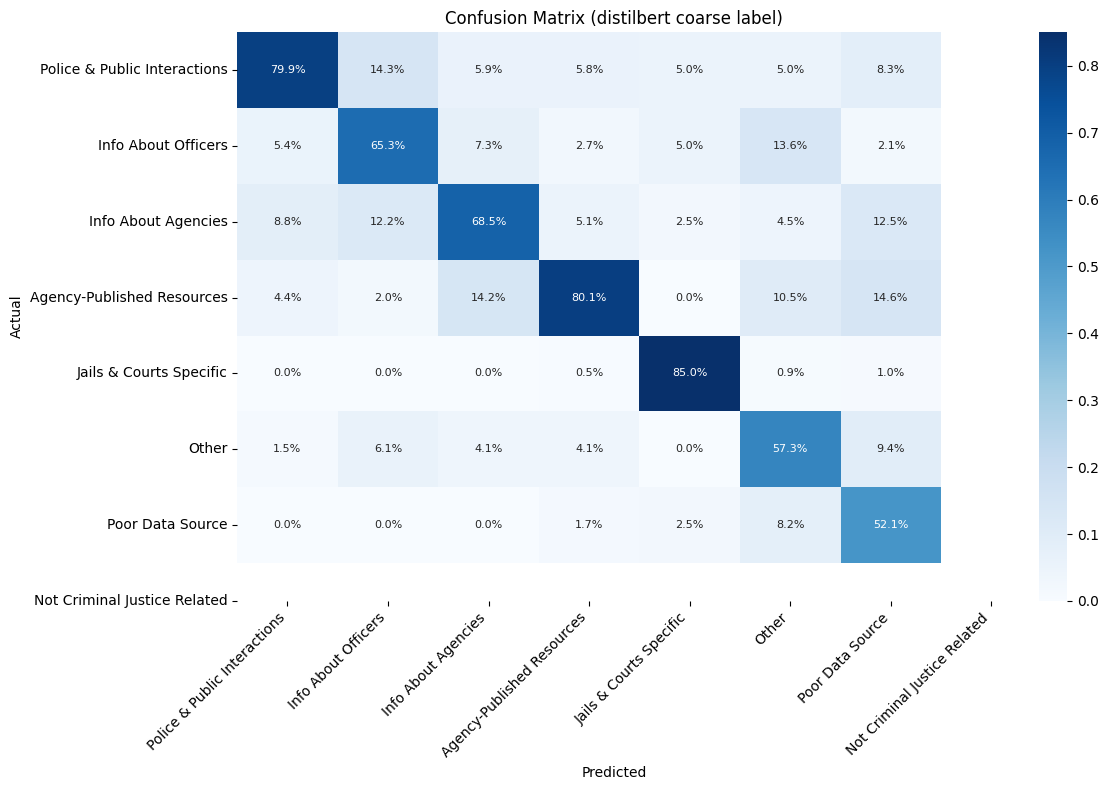

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the unique class labels
classes = np.unique(eval_labels)

# Compute confusion matrix
conf_mat = confusion_matrix(eval_labels, eval_predictions, labels=classes)

# Plot confusion matrix as percentages
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=0), annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
#sns.heatmap(conf_mat, annot=True, fmt="", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
plt.title('Confusion Matrix (distilbert coarse label)')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Actual')
plt.tight_layout()
#plt.savefig("confusion-matrix-distilbert-1_1.png", dpi=500)
plt.show()

In [18]:
classes

array(['Arrest Records', 'Calls for Service', 'Complaints & Misconduct',
       'Contact Info & Agency Meta', 'Crime Maps & Reports',
       'Crime Statistics', 'Incarceration Records',
       'List of Data Sources', 'Media Bulletins', 'Misc Police Activity',
       'Not Criminal Justice Related', 'Officer Involved Shootings',
       'Policies & Contracts', 'Poor Data Source', 'Resources', 'Stops',
       'Training & Hiring Info', 'Use of Force Reports'], dtype='<U28')

(array([ 96., 120.,  84.,  26., 326., 156.,  28., 246., 104.,  66.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

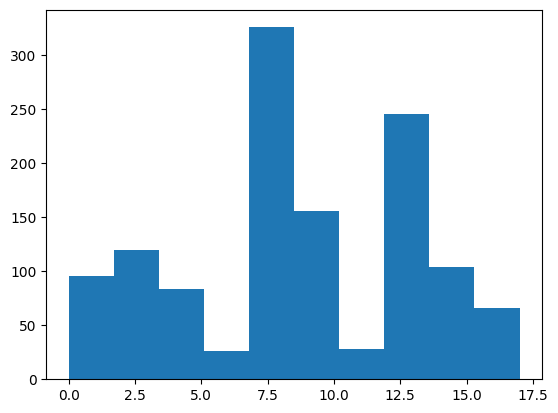

In [20]:
plt.hist(eval_labels)

/var/folders/zh/qjtgnxgd20g5nv9j7bmktmcm0000gn/T/ipykernel_17955/3618998389.py:9: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(conf_mat/conf_mat.sum(axis=0), annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})


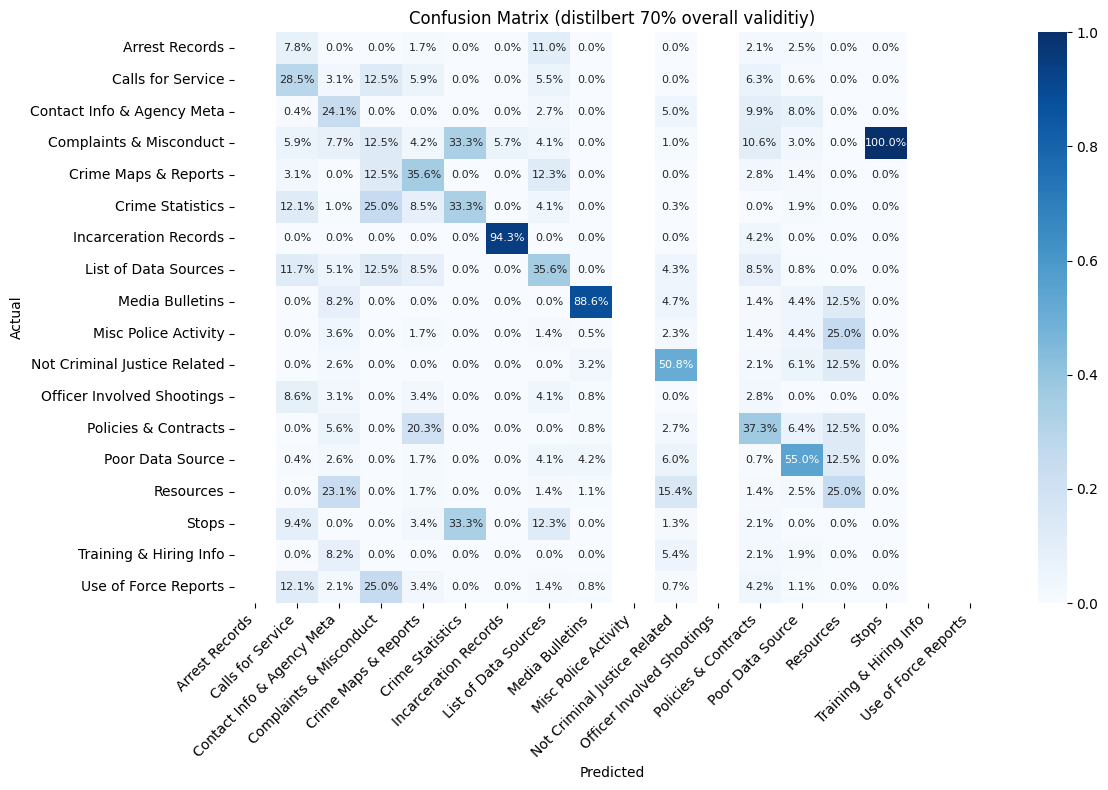

In [27]:
# Get the unique class labels
classes = np.unique(eval_labels)

# Compute confusion matrix
conf_mat = confusion_matrix(eval_labels, eval_predictions, labels=classes)

# Plot confusion matrix as percentages
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=0), annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
#sns.heatmap(conf_mat, annot=True, fmt="", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
plt.title('Confusion Matrix (distilbert 70% overall validitiy)')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Actual')
plt.tight_layout()
#plt.savefig("confusion-matrix-distilbert-1_1.png", dpi=500)
plt.show()

In [82]:
dataset == filtered_dataset

False

In [83]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 668
    })
})

In [84]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 668
    })
})

In [87]:
for i in range(10):
    print(dataset["train"][i])
    print(filtered_dataset["train"][i])
    print("\n")

{'id': 2666, 'url': 'https://coloradosprings.gov/police-department/page/alternate-education-program', 'label': 'Resources', 'coarse_label': 'Agency-Published Resources', 'http_response': 200, 'html_title': 'Alternate Education Program | City of Colorado Springs', 'meta_description': None, 'h1': '["\\nAlternate Education Program\\n"]', 'h2': '["Search", "Educational Program", "Colorado Springs Weekly", "GoCOS!", "Connect with @CityofCOS"]', 'h3': '["Do you have some college credits?", "Do you need to get some college credits?\\u00a0", "Do you have military experience?\\u00a0"]', 'h4': '["Participating Schools with CSPD AEP:"]', 'h5': '["CSU - Global\\u00a0", "Pikes Peak State College", "REPORT ONLINE"]', 'h6': '[]'}
{'id': 2666, 'url': 'https://coloradosprings.gov/police-department/page/alternate-education-program', 'label': 'Resources', 'coarse_label': 'Agency-Published Resources', 'http_response': 200, 'html_title': 'Alternate Education Program | City of Colorado Springs', 'meta_descr